In [1]:
%pip install -e ..

Obtaining file:///home/rstudio/rl4greencrab
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Using cached gymnasium-1.1.1-py3-none-any.whl.metadata (9.4 kB)
  Using cached optuna-4.4.0-py3-none-any.whl.metadata (17 kB)
  Using cached sb3_contrib-2.6.0-py3-none-any.whl.metadata (4.1 kB)
  Using cached scikit_optimize-0.10.2-py2.py3-none-any.whl.metadata (9.7 kB)
  Using cached scikit_plot-0.3.7-py3-none-any.whl.metadata (7.1 kB)
  Using cached stable_baselines3-2.6.0-py3-none-any.whl.metadata (4.8 kB)
  Using cached typing-3.7.4.3-py3-none-any.whl
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl.metadata (558 bytes)
  Using cached colorlog-6.9.0-py3-none-any.whl.metadata (10 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached nvidia_cuda_nvrtc_cu12

In [1]:
import numpy as np
import pandas as pd
from skopt import gp_minimize, gbrt_minimize 
from skopt.plots import plot_convergence, plot_objective
from rl4greencrab.envs.green_crab_monthly_env import greenCrabMonthEnv
from rl4greencrab.envs.green_crab_monthly_env_norm import greenCrabMonthEnvNormalized
from rl4greencrab import evaluate_agent, multiConstAction, simulator, environment_simulation, plot_selected_sizes
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from huggingface_hub import hf_hub_download
from stable_baselines3 import PPO, TD3
from sb3_contrib import TQC, RecurrentPPO

## Monthly Environment Simulation

In [2]:
config = {
    "w_mort_scale" : 600,
    "growth_k": 0.70,
    'random_start':True,
    # "curriculum": True
}

In [45]:
def evaluateConstAct(x):
    config = {
        "w_mort_scale" : 600,
        "growth_k": 0.70,
        'random_start':True,
        "curriculum": True
    }
    env = greenCrabMonthEnv(config)
    agent = multiConstAction(env=env, action=np.array(x))
    # rewards = simulator(env, agent).simulate()
    # out = np.mean(rewards)
    m_reward = evaluate_agent(agent=agent, ray_remote=True).evaluate(n_eval_episodes=200)
    
    return - m_reward

In [4]:
%%time
max_action = 3000
res = gp_minimize(evaluateConstAct, 3*[(0.0, max_action)], n_calls = 100, verbose=True)
res.x

Iteration No: 1 started. Evaluating function at random point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
2025-06-16 19:05:12,512	INFO worker.py:1917 -- Started a local Ray instance.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 10.9418
Function value obtained: 49.5922
Current minimum: 49.5922
Iteration No: 2 started. Evaluating function at random point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.4086
Function value obtained: 18.6053
Current minimum: 18.6053
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.3730
Function value obtained: 40.8044
Current minimum: 18.6053
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.3860
Function value obtained: 46.0228
Current minimum: 18.6053
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.3808
Function value obtained: 7.1590
Current minimum: 7.1590
Iteration No: 6 started. Evaluating function at random point.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 0.3888
Function value obtained: 42.5286
Current minimum: 7.1590
Iteration No: 7 started. Evaluating function at random point.
Iteration No: 7 ended. Evalu

/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 0.5526
Function value obtained: 21.0165
Current minimum: 7.1590
Iteration No: 12 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 0.5585
Function value obtained: 6.3416
Current minimum: 6.3416
Iteration No: 13 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.6287
Function value obtained: 6.4873
Current minimum: 6.3416
Iteration No: 14 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.5448
Function value obtained: 6.5075
Current minimum: 6.3416
Iteration No: 15 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.5251
Function value obtained: 11.3055
Current minimum: 6.3416
Iteration No: 16 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.6158
Function value obtained: 6.2819
Current minimum: 6.2819
Iteration No: 17 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.4859
Function value obtained: 7.3175
Current minimum: 6.2819
Iteration No: 18 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.5843
Function value obtained: 8.9079
Current minimum: 6.2819
Iteration No: 19 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.6329
Function value obtained: 6.2714
Current minimum: 6.2714
Iteration No: 20 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.5776
Function value obtained: 6.3752
Current minimum: 6.2714
Iteration No: 21 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.6165
Function value obtained: 7.9911
Current minimum: 6.2714
Iteration No: 22 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.6154
Function value obtained: 6.5040
Current minimum: 6.2714
Iteration No: 23 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.6215
Function value obtained: 6.7086
Current minimum: 6.2714
Iteration No: 24 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.5804
Function value obtained: 7.9351
Current minimum: 6.2714
Iteration No: 25 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.5910
Function value obtained: 6.4065
Current minimum: 6.2714
Iteration No: 26 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.5912
Function value obtained: 7.2840
Current minimum: 6.2714
Iteration No: 27 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.5725
Function value obtained: 6.4023
Current minimum: 6.2714
Iteration No: 28 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.5560
Function value obtained: 8.4259
Current minimum: 6.2714
Iteration No: 29 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.6008
Function value obtained: 8.1501
Current minimum: 6.2714
Iteration No: 30 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.5775
Function value obtained: 6.4148
Current minimum: 6.2714
Iteration No: 31 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 0.5553
Function value obtained: 6.6544
Current minimum: 6.2714
Iteration No: 32 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 0.6768
Function value obtained: 16.4288
Current minimum: 6.2714
Iteration No: 33 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 0.7575
Function value obtained: 6.6791
Current minimum: 6.2714
Iteration No: 34 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 0.8158
Function value obtained: 6.5679
Current minimum: 6.2714
Iteration No: 35 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 0.6708
Function value obtained: 9.5534
Current minimum: 6.2714
Iteration No: 36 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 0.7416
Function value obtained: 12.1138
Current minimum: 6.2714
Iteration No: 37 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 0.7715
Function value obtained: 6.4466
Current minimum: 6.2714
Iteration No: 38 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 0.7832
Function value obtained: 7.5051
Current minimum: 6.2714
Iteration No: 39 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 0.7427
Function value obtained: 6.9990
Current minimum: 6.2714
Iteration No: 40 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 0.7573
Function value obtained: 6.3492
Current minimum: 6.2714
Iteration No: 41 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 0.7228
Function value obtained: 6.8208
Current minimum: 6.2714
Iteration No: 42 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 0.6596
Function value obtained: 12.3966
Current minimum: 6.2714
Iteration No: 43 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 0.6984
Function value obtained: 7.4090
Current minimum: 6.2714
Iteration No: 44 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 0.6930
Function value obtained: 6.5252
Current minimum: 6.2714
Iteration No: 45 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 0.7607
Function value obtained: 6.2199
Current minimum: 6.2199
Iteration No: 46 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 0.7157
Function value obtained: 6.6583
Current minimum: 6.2199
Iteration No: 47 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 0.8714
Function value obtained: 6.4924
Current minimum: 6.2199
Iteration No: 48 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 0.8662
Function value obtained: 6.6686
Current minimum: 6.2199
Iteration No: 49 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 0.9124
Function value obtained: 8.2943
Current minimum: 6.2199
Iteration No: 50 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 0.9729
Function value obtained: 6.3560
Current minimum: 6.2199
Iteration No: 51 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 0.9054
Function value obtained: 6.7567
Current minimum: 6.2199
Iteration No: 52 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 0.7920
Function value obtained: 6.5018
Current minimum: 6.2199
Iteration No: 53 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 1.0415
Function value obtained: 16.1303
Current minimum: 6.2199
Iteration No: 54 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 0.9055
Function value obtained: 6.4908
Current minimum: 6.2199
Iteration No: 55 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 0.9102
Function value obtained: 6.5817
Current minimum: 6.2199
Iteration No: 56 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 0.9765
Function value obtained: 6.4321
Current minimum: 6.2199
Iteration No: 57 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 0.8875
Function value obtained: 6.5683
Current minimum: 6.2199
Iteration No: 58 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 0.9581
Function value obtained: 6.6548
Current minimum: 6.2199
Iteration No: 59 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 0.8501
Function value obtained: 6.3800
Current minimum: 6.2199
Iteration No: 60 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 1.0141
Function value obtained: 14.5071
Current minimum: 6.2199
Iteration No: 61 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 0.9906
Function value obtained: 6.4217
Current minimum: 6.2199
Iteration No: 62 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 0.9446
Function value obtained: 6.3736
Current minimum: 6.2199
Iteration No: 63 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 0.8868
Function value obtained: 6.4878
Current minimum: 6.2199
Iteration No: 64 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 0.9142
Function value obtained: 9.4375
Current minimum: 6.2199
Iteration No: 65 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 0.9605
Function value obtained: 27.6223
Current minimum: 6.2199
Iteration No: 66 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 0.9362
Function value obtained: 6.4106
Current minimum: 6.2199
Iteration No: 67 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 0.9569
Function value obtained: 8.1272
Current minimum: 6.2199
Iteration No: 68 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 1.0101
Function value obtained: 29.0649
Current minimum: 6.2199
Iteration No: 69 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 1.0620
Function value obtained: 6.8614
Current minimum: 6.2199
Iteration No: 70 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 1.0363
Function value obtained: 6.5564
Current minimum: 6.2199
Iteration No: 71 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 1.1769
Function value obtained: 6.5021
Current minimum: 6.2199
Iteration No: 72 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 1.0182
Function value obtained: 6.4299
Current minimum: 6.2199
Iteration No: 73 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 1.0948
Function value obtained: 6.3863
Current minimum: 6.2199
Iteration No: 74 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 1.0988
Function value obtained: 6.2353
Current minimum: 6.2199
Iteration No: 75 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 1.1147
Function value obtained: 6.3040
Current minimum: 6.2199
Iteration No: 76 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 1.0608
Function value obtained: 6.2889
Current minimum: 6.2199
Iteration No: 77 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 1.1019
Function value obtained: 6.4773
Current minimum: 6.2199
Iteration No: 78 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 1.0980
Function value obtained: 6.3501
Current minimum: 6.2199
Iteration No: 79 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 1.0965
Function value obtained: 6.1958
Current minimum: 6.1958
Iteration No: 80 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 1.1298
Function value obtained: 6.4082
Current minimum: 6.1958
Iteration No: 81 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 1.0914
Function value obtained: 6.2571
Current minimum: 6.1958
Iteration No: 82 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 1.0819
Function value obtained: 6.1216
Current minimum: 6.1216
Iteration No: 83 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 1.0948
Function value obtained: 6.6405
Current minimum: 6.1216
Iteration No: 84 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 1.0682
Function value obtained: 6.4398
Current minimum: 6.1216
Iteration No: 85 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 1.0890
Function value obtained: 6.4921
Current minimum: 6.1216
Iteration No: 86 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 1.0766
Function value obtained: 9.6482
Current minimum: 6.1216
Iteration No: 87 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 1.1027
Function value obtained: 6.5717
Current minimum: 6.1216
Iteration No: 88 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 1.0870
Function value obtained: 6.4204
Current minimum: 6.1216
Iteration No: 89 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 1.1268
Function value obtained: 6.5051
Current minimum: 6.1216
Iteration No: 90 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 1.2338
Function value obtained: 6.3482
Current minimum: 6.1216
Iteration No: 91 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 1.1734
Function value obtained: 6.3555
Current minimum: 6.1216
Iteration No: 92 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 1.2032
Function value obtained: 6.2337
Current minimum: 6.1216
Iteration No: 93 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 1.1871
Function value obtained: 6.5388
Current minimum: 6.1216
Iteration No: 94 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 1.2624
Function value obtained: 14.3061
Current minimum: 6.1216
Iteration No: 95 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 1.2687
Function value obtained: 6.4972
Current minimum: 6.1216
Iteration No: 96 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 1.2701
Function value obtained: 40.8747
Current minimum: 6.1216
Iteration No: 97 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 1.2847
Function value obtained: 6.2081
Current minimum: 6.1216
Iteration No: 98 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 1.2517
Function value obtained: 8.5569
Current minimum: 6.1216
Iteration No: 99 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 1.2814
Function value obtained: 6.5656
Current minimum: 6.1216
Iteration No: 100 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 1.3744
Function value obtained: 6.8495
Current minimum: 6.1216
CPU times: user 49min 10s, sys: 9.13 s, total: 49min 19s
Wall time: 1min 34s


[439.98733586238234, 794.1018039403413, 0.0]

In [46]:
# with nonNormalized env
evaluateConstAct(
    [439.98733586238234, 794.1018039403413, 0.0]
)

/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
2025-06-17 00:32:49,587	INFO worker.py:1917 -- Started a local Ray instance.


6.3741998580596055

In [47]:
import ray
ray.shutdown()

In [48]:
env = greenCrabMonthEnv(config)
agent = multiConstAction(env=env, action=np.array([0.0, 265.6788011729134, 0.0]))
constantData = simulator(env = env, agent = agent).simulate_full_named_dict_obs_acts()
constantDataDF = pd.DataFrame(constantData)
constantDataDF.head()

,t,obs0,obs1,act0,act1,act2,rew,rep
0,0,0.0,0.0,0.0,265.678801,0.0,0.000000,0
1,1,0.0,0.0,0.0,265.678801,0.0,-0.007146,0
2,2,0.0,0.0,0.0,265.678801,0.0,-0.014292,0
3,3,0.0,0.0,0.0,265.678801,0.0,-0.021438,0
4,4,0.0,0.0,0.0,265.678801,0.0,-0.028584,0


<Axes: xlabel='t'>

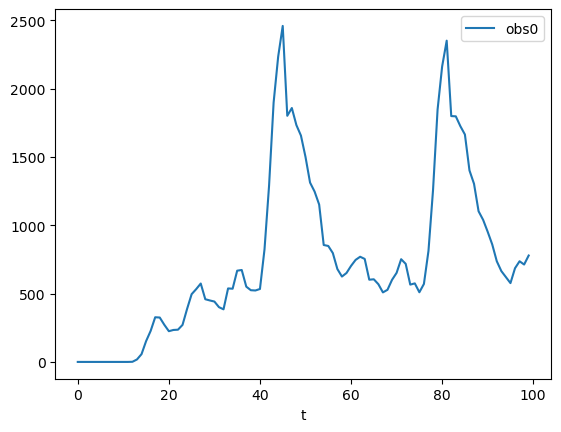

In [49]:
constantDataDF[constantDataDF.rep == 0].plot(x='t', y =['obs0'])

In [50]:
agent = multiConstAction(env=env, action=np.array([0.0, 0, 0.0]))
constantData = environment_simulation(env, agent)
constantDataDF = pd.DataFrame(constantData)
constantDataDF.head()

,t,obs0,obs1,act0,act1,act2,rew,rep,crab_pop
0,0,0.0,0.0,0.0,0.0,0.0,0.000000,0,"[0.0002598560294824107, 0.004307844136430026, ..."
1,1,0.0,0.0,0.0,0.0,0.0,-0.264998,0,"[303.75259653145457, 4592.876555410989, 18142...."
2,2,0.0,0.0,0.0,0.0,0.0,-0.529998,0,"[31.5861204411194, 734.0905708981785, 5572.546..."
3,3,0.0,0.0,0.0,0.0,0.0,-0.794998,0,"[3.4017319538243362, 109.18791950483491, 1269...."
4,4,0.0,0.0,0.0,0.0,0.0,-1.059998,0,"[0.3657273962692726, 15.7893150734233, 255.326..."


In [51]:
crab_pop_df = pd.DataFrame(constantDataDF[constantDataDF['rep']==0]['crab_pop'].tolist(), columns=[f'crab_pop_{i}' for i in range(len(constantDataDF['crab_pop'][0]))])
crab_pop_df['t'] = constantDataDF['t']
crab_pop_df.head()

,crab_pop_0,crab_pop_1,crab_pop_2,crab_pop_3,crab_pop_4,crab_pop_5,crab_pop_6,crab_pop_7,crab_pop_8,crab_pop_9,...,crab_pop_12,crab_pop_13,crab_pop_14,crab_pop_15,crab_pop_16,crab_pop_17,crab_pop_18,crab_pop_19,crab_pop_20,t
0,0.000260,0.004308,0.049211,0.387660,2.107241,7.908961,20.506623,36.746259,45.518556,38.981839,...,2.669452,0.521091,0.070198,0.006522,0.000418,0.000018,5.587596e-07,1.166134e-08,1.672906e-10,0
1,303.752597,4592.876555,18142.817528,16943.492887,5260.709502,522.431161,8.449192,0.498955,8.642530,59.911103,...,1490.671166,2056.174308,1992.222180,1392.212997,757.373005,393.864979,2.430827e+02,1.649208e+02,8.572222e+01,1
2,31.586120,734.090571,5572.546923,15678.052302,15318.092912,6031.602825,986.949294,60.141346,4.225230,30.522772,...,1157.137212,1835.683910,2044.575096,1614.193595,965.283292,503.477400,2.826378e+02,1.770177e+02,8.940761e+01,2
3,3.401732,109.187920,1269.073938,6389.384889,14275.076830,13679.520986,6004.279820,1251.257253,122.160243,19.580556,...,868.197699,1566.872548,1984.331199,1782.032781,1180.313867,636.462799,3.375904e+02,1.945085e+02,9.322659e+01,3
4,0.365727,15.789315,255.326523,1926.594834,7205.685086,13352.116484,12095.730417,5503.975918,1293.869069,164.046927,...,630.635042,1293.199171,1845.984842,1872.014144,1377.718808,787.289434,4.097538e+02,2.187356e+02,9.923867e+01,4


In [54]:
# Create a multi-select widget for crab size columns
crab_pop_columns = [col for col in crab_pop_df.columns if col.startswith('crab_pop_')]
size_selector = widgets.SelectMultiple(
    options=crab_pop_columns,
    value=[crab_pop_columns[0]],  # Default selection
    description='Sizes',
    disabled=False
)
# Create an interactive plot
interact(lambda selected_sizes: plot_selected_sizes(crab_pop_df, selected_sizes), selected_sizes=size_selector);

interactive(children=(SelectMultiple(description='Sizes', index=(0,), options=('crab_pop_0', 'crab_pop_1', 'cr…

### normalized environment

In [29]:
config = {
    "w_mort_scale" : 600,
    "growth_k": 0.70,
    'random_start':True,
    # "curriculum": True
}

In [30]:
env = greenCrabMonthEnvNormalized(config)

In [31]:
def evaluateConstAct(x):
    env = greenCrabMonthEnvNormalized(config)
    agent = multiConstAction(env=env, action=np.array(x))
    # rewards = simulator(env, agent).simulate()
    # out = np.mean(rewards)
    rewards = evaluate_agent(agent=agent, ray_remote=True).evaluate(n_eval_episodes=200, return_episode_rewards=True)
    m_reward = np.mean(rewards)
    return -m_reward, rewards

In [32]:
# normalized constant action
def normalized_action(act, max_act):
    max_action = max_act
    constant_act = np.array(act)
    return constant_act * 2 / max_action - 1 

In [33]:
norm_act = normalized_action([439.98733586238234, 794.1018039403413, 0.0], 3000)
m_reward, const_rews = evaluateConstAct(norm_act)
np.mean(const_rews)

2025-06-16 19:12:27,937	INFO worker.py:1917 -- Started a local Ray instance.


-6.265168740010433

In [34]:
import ray
ray.shutdown()

In [35]:
agent = multiConstAction(env=env, action=np.array(norm_act))

In [36]:
constantData = simulator(env = env, agent = agent).simulate_full_named_dict_obs_acts()
constantDataDF = pd.DataFrame(constantData)
constantDataDF.head()

,t,obs0,obs1,act0,act1,act2,rew,rep
0,0,-1.0,-1.0,-0.706675,-0.470599,-1.0,0.000000,0
1,1,-1.0,-1.0,-0.706675,-0.470599,-1.0,-0.032970,0
2,2,-1.0,-1.0,-0.706675,-0.470599,-1.0,-0.065941,0
3,3,-1.0,-1.0,-0.706675,-0.470599,-1.0,-0.098911,0
4,4,-1.0,-1.0,-0.706675,-0.470599,-1.0,-0.131881,0


<Axes: xlabel='t'>

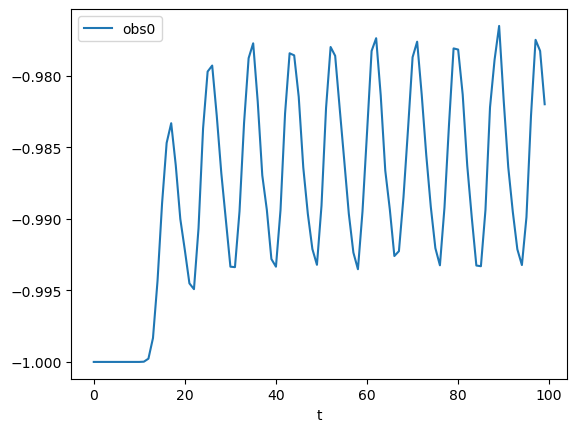

In [37]:
constantDataDF[constantDataDF.rep == 0].plot(x='t', y =['obs0'])

## Loading and evaluating trained models

In [52]:
repo_id = "jimjiang203/greencrabPPO"
td3_path = hf_hub_download(repo_id=repo_id, filename='td3_gcmonthnorm.zip')
ppo_path = hf_hub_download(repo_id=repo_id, filename='PPO_gcmenorm.zip')
reppo_path = hf_hub_download(repo_id=repo_id, filename='RecurrentPPO_gcmenorm.zip')
tqc_path = hf_hub_download(repo_id=repo_id, filename='TQC_gcmenorm.zip')

In [55]:
evalEnv = greenCrabMonthEnvNormalized(config)

/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [56]:
path = "../saved_agents"
td3Agent = TD3.load(f"TD3_gcmenorm", device="cpu")
ppoAgent = PPO.load(f"PPO_gcmenorm", device="cpu")
tqcAgent = TQC.load(f"TQC_gcmenorm", device="cpu")
recurrentPPOAgent = RecurrentPPO.load("RecurrentPPO_gcmenorm", device="cpu")

In [57]:
N_EPS = 30

ppo_rew = evaluate_agent(agent=ppoAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)
td3_rew = evaluate_agent(agent=td3Agent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)
tqc_rew = evaluate_agent(agent=tqcAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)
reppo_rew = evaluate_agent(agent=recurrentPPOAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)

2025-06-17 17:03:26,505	INFO worker.py:1917 -- Started a local Ray instance.


In [58]:
N_EPS = 200

ppo_rews = evaluate_agent(agent=ppoAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS, return_episode_rewards=True)
td3_rews = evaluate_agent(agent=td3Agent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS, return_episode_rewards=True)
tqc_rews = evaluate_agent(agent=tqcAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS, return_episode_rewards=True)
reppo_rews = evaluate_agent(agent=recurrentPPOAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS, return_episode_rewards=True)

In [59]:
import ray
ray.shutdown()

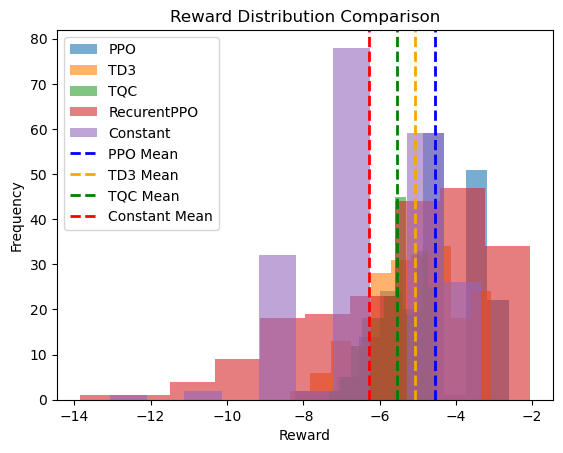

In [60]:
plt.hist(ppo_rews, alpha=0.6, label='PPO')
plt.hist(td3_rews, alpha=0.6, label='TD3')
plt.hist(tqc_rews, alpha=0.6, label='TQC')
plt.hist(reppo_rews , alpha=0.6, label='RecurentPPO')
plt.hist(const_rews, alpha=0.6, label='Constant')

# Mark means with vertical lines
plt.axvline(np.mean(ppo_rews), color='blue', linestyle='dashed', linewidth=2, label='PPO Mean')
plt.axvline(np.mean(td3_rews), color='orange', linestyle='dashed', linewidth=2, label='TD3 Mean')
plt.axvline(np.mean(tqc_rews), color='green', linestyle='dashed', linewidth=2, label='TQC Mean')
plt.axvline(np.mean(const_rews), color='red', linestyle='dashed', linewidth=2, label='Constant Mean')

plt.legend()
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.title("Reward Distribution Comparison")
plt.show()

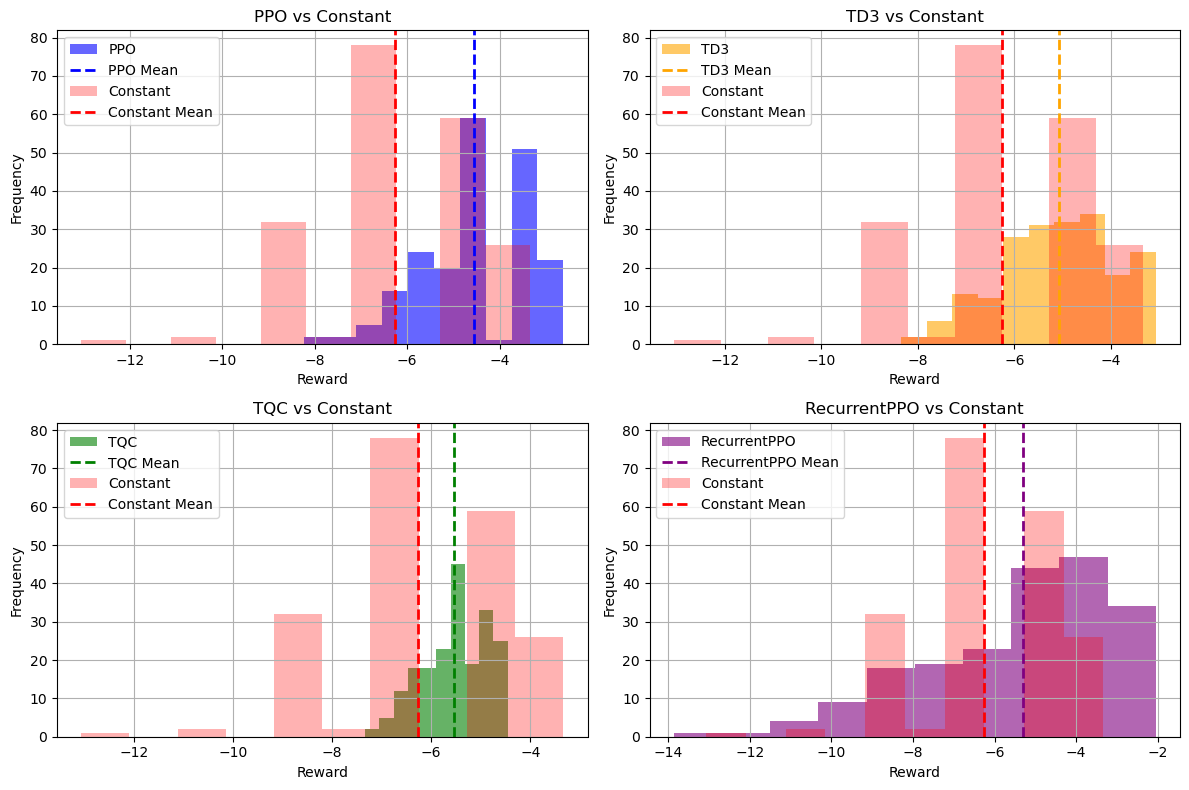

In [61]:
models = {
    'PPO': ppo_rews,
    'TD3': td3_rews,
    'TQC': tqc_rews,
    'RecurrentPPO': reppo_rews,
}
constant_rewards = const_rews

colors = {
    'PPO': 'blue',
    'TD3': 'orange',
    'TQC': 'green',
    'RecurrentPPO': 'purple',
    'Constant': 'red'
}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

for i, (model_name, rewards) in enumerate(models.items()):
    ax = axes[i]
    # Plot current model
    ax.hist(rewards, alpha=0.6, color=colors[model_name], label=model_name)
    ax.axvline(np.mean(rewards), color=colors[model_name], linestyle='dashed', linewidth=2, label=f'{model_name} Mean')

    # Plot constant model
    ax.hist(constant_rewards, alpha=0.3, color=colors['Constant'], label='Constant')
    ax.axvline(np.mean(constant_rewards), color=colors['Constant'], linestyle='dashed', linewidth=2, label='Constant Mean')

    ax.set_title(f"{model_name} vs Constant")
    ax.set_xlabel("Reward")
    ax.set_ylabel("Frequency")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

In [26]:
np.std(ppo_rews), np.std(td3_rews), np.std(tqc_rews), np.std(reppo_rews)

(0.49128625727392095,
 0.4300019395754943,
 0.30248493616568156,
 1.5750607451925227)

In [69]:
np.mean(ppo_rews), np.mean(td3_rews), np.mean(tqc_rews), np.mean(reppo_rews)

(-4.560745831476809, -5.06953504210659, -5.543690708228613, -5.302503810449402)

In [62]:
print(f"""
PPO mean rew = {ppo_rew}
TQC mean rew = {tqc_rew}
TD3 mean rew = {td3_rew}
RecurrentPPO mean rew = {reppo_rew}
""")


PPO mean rew = -4.966421639589972
TQC mean rew = -5.681620240714175
TD3 mean rew = -4.888475699825501
RecurrentPPO mean rew = -5.53858242899152



### RL action plots

In [63]:
ppoData = simulator(env = evalEnv, agent = ppoAgent).simulate_full_named_dict_obs_acts()
ppoDataDF = pd.DataFrame(ppoData)
ppoDataDF.head()

,t,obs0,obs1,act0,act1,act2,rew,rep
0,0,-1.0,-1.0,-0.847923,-0.785029,-1.0,0.000000,0
1,1,-1.0,-1.0,-0.469561,-0.546114,-1.0,-0.014743,0
2,2,-1.0,-1.0,-0.810173,-0.604385,-1.0,-0.054177,0
3,3,-1.0,-1.0,-0.771991,-0.776256,-1.0,-0.077656,0
4,4,-1.0,-1.0,-0.256207,-0.645503,-1.0,-0.095788,0


<Axes: xlabel='t'>

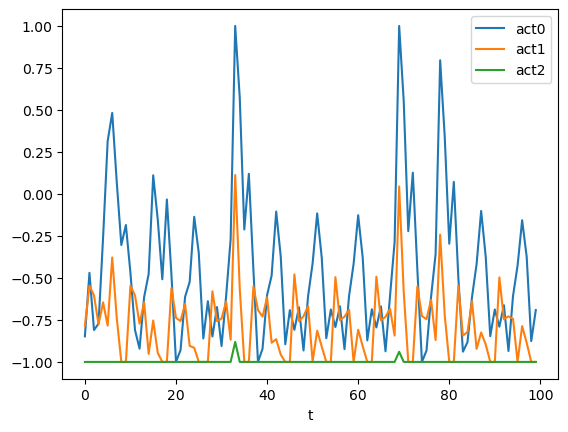

In [64]:
ppoDataDF[ppoDataDF.rep == 0].plot(x='t', y =['act0', 'act1', 'act2'])

<Axes: xlabel='t'>

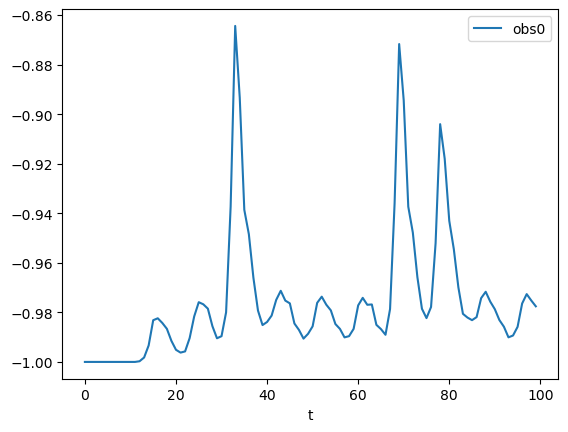

In [65]:
ppoDataDF[ppoDataDF.rep == 0].plot(x='t', y =['obs0'])

In [66]:
ppoData = simulator(env = evalEnv, agent = recurrentPPOAgent).simulate_full_named_dict_obs_acts()
ppoDataDF = pd.DataFrame(ppoData)
ppoDataDF.head()

,t,obs0,obs1,act0,act1,act2,rew,rep
0,0,-1.000000,-1.000000,-1.000000,-1.000000,-0.721052,0.000000,0
1,1,-0.903973,-0.978074,-0.995995,-0.756041,-1.000000,-0.055951,0
2,2,-0.994730,3.071748,-0.813516,-0.738470,-1.000000,-0.066103,0
3,3,-0.993840,1.670866,-1.000000,-1.000000,-1.000000,-0.084414,0
4,4,-1.000000,-1.000000,-0.164519,-1.000000,-1.000000,-0.085233,0


<Axes: xlabel='t'>

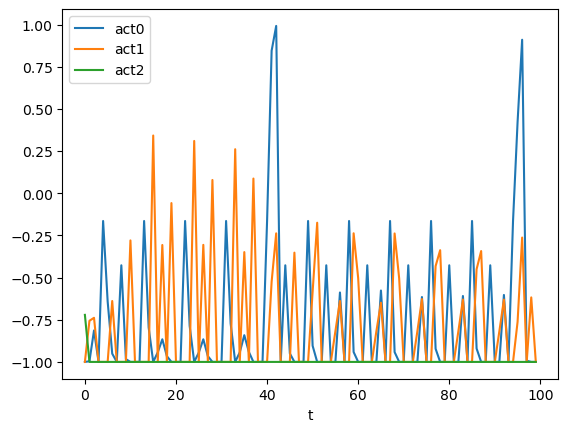

In [67]:
ppoDataDF[ppoDataDF.rep == 0].plot(x='t', y =['act0', 'act1', 'act2'])

<Axes: xlabel='t'>

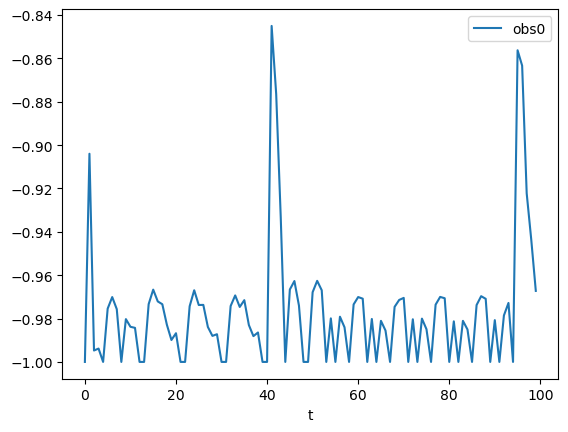

In [68]:
ppoDataDF[ppoDataDF.rep == 0].plot(x='t', y =['obs0'])

## Special Section: Testing ensemble PPO

In [9]:
from ensemble_ppo import *

In [56]:
eppoAgent = EnsemblePPO.load('ensemblePPO_gcmenorm')

Loading ensemblePPO_gcmenorm/model_1.zip …


In [57]:
obs = {
    "crabs": np.array([1, 1]),
    "months" : 4 
}
eppoAgent.predict(obs)

(array([-0.03874406,  0.3987172 ,  1.        ], dtype=float32), None)

In [58]:
N_EPS = 30
eppo_rews = evaluate_agent(agent=eppoAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS, return_episode_rewards=True)

2025-06-16 18:37:01,363	INFO worker.py:1888 -- Started a local Ray instance.


In [59]:
import ray
ray.shutdown()

In [60]:
np.mean(eppo_rews)

-2.4034102689903323

In [61]:
ppoData = simulator(env = evalEnv, agent = eppoAgent).simulate_full_named_dict_obs_acts()
ppoDataDF = pd.DataFrame(ppoData)
ppoDataDF.head()

,t,obs0,obs1,act0,act1,act2,rew,rep
0,0,-1.000000,-1.000000,-0.974713,-0.849815,-1.0,0.000000,0
1,1,-0.979864,0.376640,-1.000000,1.000000,-1.0,-0.011415,0
2,2,-0.979767,-0.416228,-0.637097,-0.391289,-1.0,-0.092169,0
3,3,-0.983821,-0.119736,-1.000000,-1.000000,-1.0,-0.131576,0
4,4,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.132317,0


<Axes: xlabel='t'>

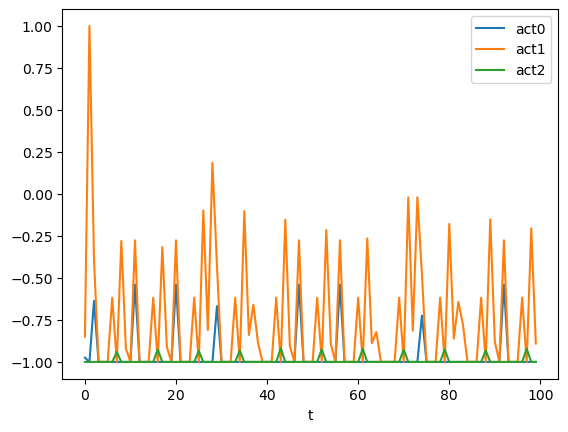

In [62]:
ppoDataDF[ppoDataDF.rep == 0].plot(x='t', y =['act0', 'act1', 'act2'])